In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy as sp
from plot_lib import *

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

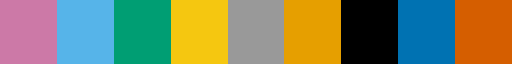

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_hepg2 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_HepG2.tsv", sep="\t")

In [7]:
hepg2 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_HepG2_with_ppi_with_dnase_with_atac_with_motifs_with_ccres_cleaned.tsv", sep="\t")

hepg2 = hepg2.loc[hepg2.is_M2Kb & (hepg2.is_pls | hepg2.is_pels | hepg2.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
hepg2 = hepg2.loc[hepg2.tf.isin(collectri.source) & hepg2.tf.isin(chip_atlas_hepg2.tf)]
hepg2.shape

(888563, 2)

In [8]:
chip_atlas_hepg2 = chip_atlas_hepg2.loc[chip_atlas_hepg2.tf.isin(hepg2.tf)]
chip_atlas_hepg2.shape

(2454102, 2)

In [9]:
collectri = collectri[collectri.source.isin(hepg2.tf)]

### Prepare cosmic

In [10]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# Liver cancer dataset

In [11]:
adata_blast = sc.read_h5ad("../data/case_study/blastoma.h5ad")
adata_blast.shape

(67110, 33234)

In [12]:
adata_blast.obs.head()

,author_sample_group,author_sample_id,donor_id,assay_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,tissue_ontology_term_id,nCount_RNA,...,hca_data_portal_donor_uuid,hca_data_portal_cellsuspension_uuid,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
barcode,,,,,,,,,,,,,,,,,,,,,
hb17-background_AAACCCAGTACGGTTT-1,background,hb17-background,hb17,EFO:0009922,unknown,PATO:0000461,True,NCBITaxon:9606,UBERON:0002107,6579,...,6780beb4-9e22-40f7-a2d4-4ffa86ed43ec,80b1490e-19a4-4679-979a-114f58e36409,hepatocyte,10x 3' v3,normal,Homo sapiens,unknown,liver,unknown,unknown
hb17-background_AAACCCATCGAGTCCG-1,background,hb17-background,hb17,EFO:0009922,unknown,PATO:0000461,True,NCBITaxon:9606,UBERON:0002107,5347,...,6780beb4-9e22-40f7-a2d4-4ffa86ed43ec,80b1490e-19a4-4679-979a-114f58e36409,hepatocyte,10x 3' v3,normal,Homo sapiens,unknown,liver,unknown,unknown
hb17-background_AAACCCATCGTTGCCT-1,background,hb17-background,hb17,EFO:0009922,unknown,PATO:0000461,True,NCBITaxon:9606,UBERON:0002107,11950,...,6780beb4-9e22-40f7-a2d4-4ffa86ed43ec,80b1490e-19a4-4679-979a-114f58e36409,hepatocyte,10x 3' v3,normal,Homo sapiens,unknown,liver,unknown,unknown
hb17-background_AAACGAATCTCATTTG-1,background,hb17-background,hb17,EFO:0009922,unknown,PATO:0000461,True,NCBITaxon:9606,UBERON:0002107,7642,...,6780beb4-9e22-40f7-a2d4-4ffa86ed43ec,80b1490e-19a4-4679-979a-114f58e36409,hepatocyte,10x 3' v3,normal,Homo sapiens,unknown,liver,unknown,unknown
hb17-background_AAACGCTAGGCTCAAG-1,background,hb17-background,hb17,EFO:0009922,unknown,PATO:0000461,True,NCBITaxon:9606,UBERON:0002107,3122,...,6780beb4-9e22-40f7-a2d4-4ffa86ed43ec,80b1490e-19a4-4679-979a-114f58e36409,hepatic stellate cell,10x 3' v3,normal,Homo sapiens,unknown,liver,unknown,unknown


In [13]:
adata_blast.obs.cell_type.value_counts()

cell_type
neoplastic cell          52431
hepatocyte                6720
endothelial cell          2697
Kupffer cell              2682
hepatic stellate cell     1036
mature NK T cell           930
erythrocyte                221
neuron                     197
cholangiocyte              142
lymphocyte                  28
B cell                      26
Name: count, dtype: int64

In [14]:
adata_blast_liver = adata_blast[adata_blast.obs.cell_type.isin(["hepatocyte", "neoplastic cell"])]

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters

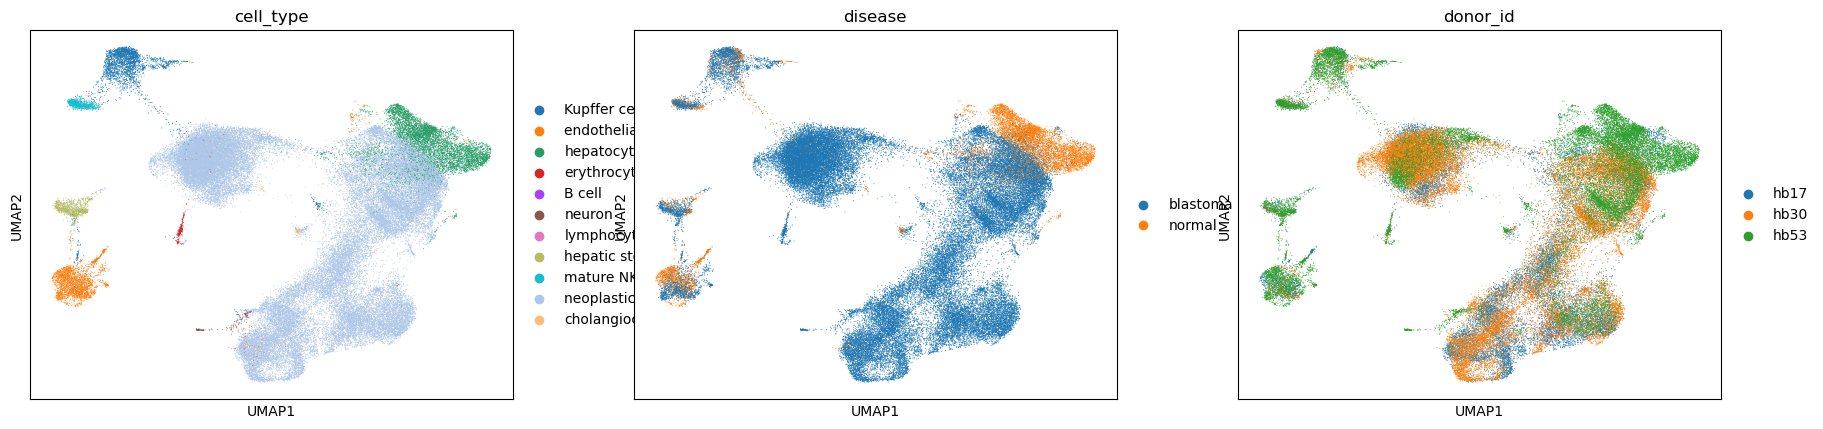

In [15]:
sc.pl.umap(adata_blast, color=["cell_type", "disease", "donor_id"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avo

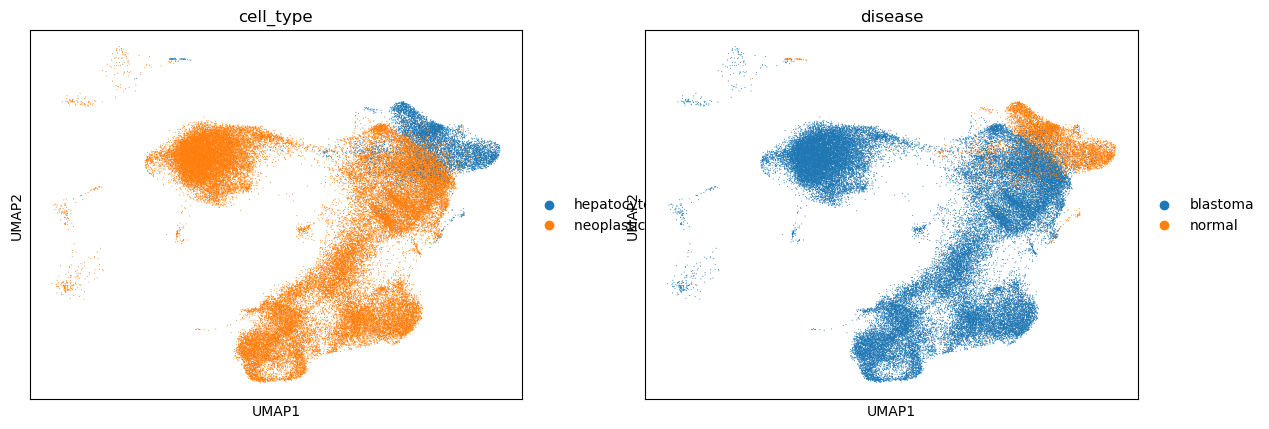

In [16]:
sc.pl.umap(adata_blast_liver, color=["cell_type", "disease"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


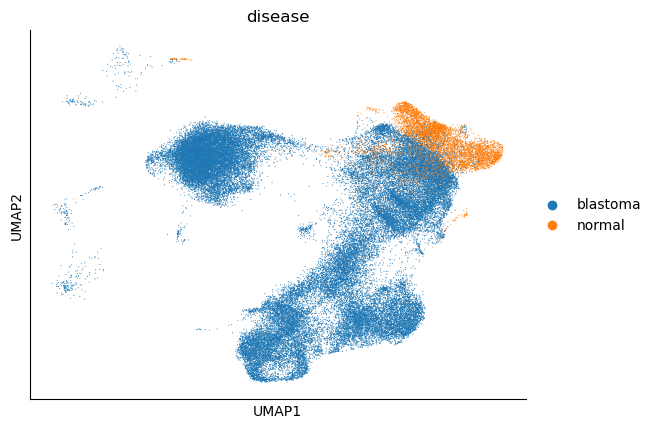

In [17]:
fig, ax = plt.subplots()

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

sc.pl.umap(adata_blast_liver, color="disease", ax=ax)

In [18]:
adata_blast_liver.obs[["cell_type", "disease"]].value_counts()

cell_type        disease 
neoplastic cell  blastoma    52431
hepatocyte       normal       6720
Name: count, dtype: int64

In [19]:
adata_blast_norm = adata_blast[adata_blast.obs.disease == 'normal']
adata_blast_sub = adata_blast[adata_blast.obs.disease == 'blastoma']
sc.pp.subsample(adata_blast_sub, fraction=0.15)
adata_blast_sub = adata_blast_sub.concatenate(adata_blast_norm)

/scratch/47227602/ipykernel_16201/3929404531.py:4: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


In [20]:
adata_blast_sub.obs.disease.value_counts()

disease
normal      9665
blastoma    8616
Name: count, dtype: int64

In [21]:
sc.tl.rank_genes_groups(adata_blast_sub, groupby='disease', method='wilcoxon', use_raw=False, reference='normal')

/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


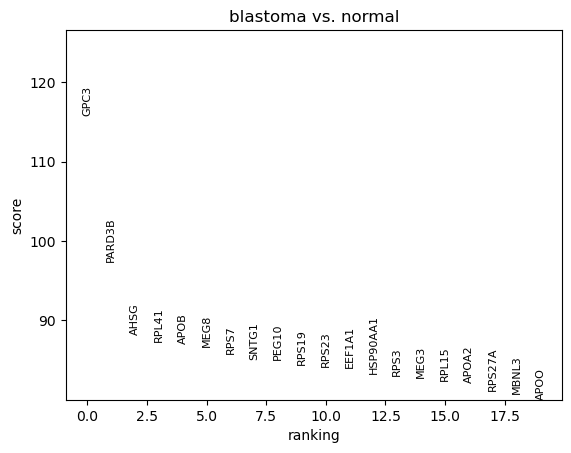

In [22]:
sc.pl.rank_genes_groups(adata_blast_sub, sharey=False, gene_symbols="feature_name")

In [23]:
hep_disreg_enrich = pd.DataFrame()
hep_omim_enrich = pd.DataFrame()
hep_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

In [24]:
de_genes = sc.get.rank_genes_groups_df(adata_blast_sub, group=None,  pval_cutoff=1e-2, gene_symbols="feature_name")

de_genes["group"] = "blastoma"
de_genes.index = pd.MultiIndex.from_frame(de_genes[["feature_name", "group"]])
de_genes

de_genes = de_genes["logfoldchanges"].unstack(level=1).T
de_genes.head()

de_genes = de_genes.loc[:, ~de_genes.T.blastoma.isna().T]

In [25]:
enr = gp.enrich(de_genes.loc[:, (de_genes.T.blastoma.abs() > 1).T].columns.to_list(), "DisGeNET")

enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Liver Cirrhosis, Experimental",425/801,2.242091e-11,2.164739e-07,0,0,1.613864,3.957359e+01,WIPF1;ABAT;SLC4A4;GLS;SMC2;LURAP1L;CYP2D6;MYC;...
1,DisGeNET,Colorectal Neoplasms,537/1073,7.732720e-09,3.031889e-05,0,0,1.430447,2.671762e+01,TFRC;SERPINE2;SERPINE1;IPP;TMEM97;CLDN2;SMC3;C...
2,DisGeNET,Colonic Neoplasms,401/778,9.420680e-09,3.031889e-05,0,0,1.513960,2.797851e+01,SERPINE1;ENO1;CLDN1;MYC;FDXR;AKT1;PRKCD;SCRIB;...
3,DisGeNET,Liver neoplasms,646/1321,2.369372e-08,5.719071e-05,0,0,1.368512,2.402841e+01,ATF2;NCKAP1;TRIO;TFRC;SERPINE1;ENO1;CLDN1;BACH...
4,DisGeNET,Prostatic Neoplasms,744/1554,1.533898e-07,2.961957e-04,0,0,1.314054,2.061788e+01,ITSN2;SERPINE2;ITSN1;SERPINE1;ENO1;ELK1;CAPNS1...
...,...,...,...,...,...,...,...,...,...,...
9650,DisGeNET,Oral candidiasis,2/29,9.999935e-01,9.999964e-01,0,0,0.103496,6.682749e-07,APCS;B2M
9651,DisGeNET,Myasthenia Gravis,43/179,9.999943e-01,9.999964e-01,0,0,0.439787,2.487391e-06,IL1RN;CALCA;ABCB1;CHRNA4;TNFAIP3;ADRB2;HMGB1;T...
9652,DisGeNET,Non-medullary thyroid carcinoma,13/82,9.999956e-01,9.999964e-01,0,0,0.262636,1.154765e-06,REG3A;PTEN;ASAP1;PIK3CB;PPP2R5C;DICER1;ASAP2;M...
9653,DisGeNET,Familial Nonmedullary Thyroid Cancer,6/65,9.999960e-01,9.999964e-01,0,0,0.141765,5.622889e-07,ZEB2;ZEB1;CCDC6;PPP2R5C;DICER1;HABP2


CollecTri

In [26]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri)#, weight=None)

In [27]:
mask_ctri = tf_pvals_ctri < 0.05

active_tfs_ctri = tf_acts_ctri.loc[:, pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].columns.to_list()

In [28]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/hep_activity_collectri.tsv", sep="\t", index=False)

In [29]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_omim_enrich_collectri.tsv", sep="\t", index=False)
hep_omim_enrich = pd.concat([hep_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [30]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_disgenet_enrich_collectri.tsv", sep="\t", index=False)
hep_disreg_enrich = pd.concat([hep_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [31]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/hep_cosmic_enrich_collectri.tsv", sep="\t", index=False)
    hep_cosmic_enrich = pd.concat([hep_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    hep_cosmic_enrich = pd.concat([hep_cosmic_enrich, pd.DataFrame()], axis=0)

In [32]:
heat = pd.concat([tf_acts_ctri.rename({"blastoma": "score"}), tf_pvals_ctri.rename({"blastoma": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID1A,-1.561903,1.183406e-01,CollecTri
ARID3A,1.345964,1.783428e-01,CollecTri
ARNT,-5.466503,4.693733e-08,CollecTri
ATF1,-0.347358,7.283294e-01,CollecTri
ATF2,-3.605987,3.123932e-04,CollecTri
...,...,...,...
ZEB1,0.886648,3.752884e-01,CollecTri
ZGPAT,2.239882,2.511914e-02,CollecTri
ZHX2,-3.517874,4.368355e-04,CollecTri
ZNF143,0.809040,4.185104e-01,CollecTri


HepG2

In [33]:
tf_acts_hepg2, tf_pvals_hepg2 = dc.run_ulm(de_genes, hepg2, source='tf', target='gene_symbol', weight=None)

In [34]:
mask_hepg2 = tf_pvals_hepg2 < 0.05

active_tfs_hepg2 = tf_acts_hepg2.loc[:, pd.DataFrame(tf_acts_hepg2 * mask_hepg2).sum(axis=0) != 0].columns.to_list()

In [35]:
tf_acts_hepg2.index = ["score"]
tf_pvals_hepg2.index = ["p_value"]
out_hepg2 = pd.merge(left=tf_acts_hepg2.T, right=tf_pvals_hepg2.T, left_index=True, right_index=True)
out_hepg2.to_csv("../data/3-tf_activity/hep_activity_m2kb.tsv", sep="\t", index=False)

In [36]:
enr = gp.enrich(active_tfs_hepg2, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_HepG2"
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_omim_enrich_m2kb_hepg2.tsv", sep="\t", index=False)
hep_omim_enrich = pd.concat([hep_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [37]:
enr = gp.enrich(active_tfs_hepg2, "DisGeNET")
enr.results["Network"] = "M2Kb_HepG2"
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_disgenet_enrich_m2kb_hepg2.tsv", sep="\t", index=False)
hep_disreg_enrich = pd.concat([hep_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [38]:
try:
    enr = gp.enrich(gene_list=active_tfs_hepg2, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_HepG2"
    enr.results.to_csv("../data/3-tf_disease_enrichment/hep_cosmic_enrich_m2kb_hepg2.tsv", sep="\t", index=False)
    hep_cosmic_enrich = pd.concat([hep_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_HepG2"
    hep_cosmic_enrich = pd.concat([hep_cosmic_enrich, pd.DataFrame()], axis=0)

In [39]:
heat = pd.concat([tf_acts_hepg2.rename({"blastoma": "score"}), tf_pvals_hepg2.rename({"blastoma": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_HepG2"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID1A,-1.561903,1.183406e-01,CollecTri
ARID3A,1.345964,1.783428e-01,CollecTri
ARNT,-5.466503,4.693733e-08,CollecTri
ATF1,-0.347358,7.283294e-01,CollecTri
ATF2,-3.605987,3.123932e-04,CollecTri
...,...,...,...
ZNF263,5.166260,2.431522e-07,M2Kb_HepG2
ZNF274,5.801593,6.756289e-09,M2Kb_HepG2
ZNF384,6.484862,9.275525e-11,M2Kb_HepG2
ZNF503,2.705671,6.827528e-03,M2Kb_HepG2


chip_atlas_hepg2

In [40]:
tf_acts_chip_atlas_hepg2, tf_pvals_chip_atlas_hepg2 = dc.run_ulm(de_genes, chip_atlas_hepg2.drop_duplicates(), 
                                                                 source='tf', target='Target_genes', weight=None)

#tf_pvals_chip_atlas_hepg2.loc["blastoma"] = fdrcorrection(tf_pvals_chip_atlas_hepg2.T["blastoma"])[1]

In [41]:
mask_chip_atlas_hepg2 = tf_pvals_chip_atlas_hepg2 < 0.05

active_tfs_chip_atlas_hepg2 = tf_acts_chip_atlas_hepg2.loc["blastoma", pd.DataFrame(tf_acts_chip_atlas_hepg2 * mask_chip_atlas_hepg2).sum(axis=0) != 0].index.to_list()
tf_acts_chip_atlas_hepg2.loc["blastoma", pd.DataFrame(tf_acts_chip_atlas_hepg2 * mask_chip_atlas_hepg2).sum(axis=0) != 0]

ARID3A    2.566732
ARID4A    2.318179
ATF1      6.716107
ATF2      3.879369
ATF3      2.162319
            ...   
ZNF224    5.120258
ZNF24     4.663704
ZNF256    6.060678
ZNF274    3.705079
ZNF503    3.038099
Name: blastoma, Length: 119, dtype: float32

In [42]:
tf_acts_chip_atlas_hepg2.index = ["score"]
tf_pvals_chip_atlas_hepg2.index = ["p_value"]
out_chip_atlas_hepg2 = pd.merge(left=tf_acts_chip_atlas_hepg2.T, right=tf_pvals_chip_atlas_hepg2.T, left_index=True, right_index=True)
out_chip_atlas_hepg2.to_csv("../data/3-tf_activity/hep_activity_ca_hepg2.tsv", sep="\t", index=False)

In [43]:
enr = gp.enrich(active_tfs_chip_atlas_hepg2, "OMIM_Expanded")
enr.results["Network"] = "CA_HepG2"
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_omim_enrich_ca_hepg2.tsv", sep="\t", index=False)
hep_omim_enrich = pd.concat([hep_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [44]:
enr = gp.enrich(active_tfs_chip_atlas_hepg2, "DisGeNET")
enr.results["Network"] = "CA_HepG2"
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_disgenet_enrich_ca_hepg2.tsv", sep="\t", index=False)
hep_disreg_enrich = pd.concat([hep_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [45]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_hepg2, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_HepG2"
    enr.results.to_csv("../data/3-tf_disease_enrichment/hep_cosmic_enrich_ca_hepg2.tsv", sep="\t", index=False)
    hep_cosmic_enrich = pd.concat([hep_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_HepG2"
    hep_cosmic_enrich = pd.concat([hep_cosmic_enrich, pd.DataFrame()], axis=0)

In [46]:
heat = pd.concat([tf_acts_chip_atlas_hepg2.rename({"blastoma": "score"}), tf_pvals_chip_atlas_hepg2.rename({"blastoma": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("blastoma", ascending=False).index).head(5)
heat["Network"] = "CA_HepG2"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID1A,-1.561903,1.183406e-01,CollecTri
ARID3A,1.345964,1.783428e-01,CollecTri
ARNT,-5.466503,4.693733e-08,CollecTri
ATF1,-0.347358,7.283294e-01,CollecTri
ATF2,-3.605987,3.123932e-04,CollecTri
...,...,...,...
ZNF263,1.884277,5.955476e-02,CA_HepG2
ZNF274,3.705079,2.123963e-04,CA_HepG2
ZNF384,1.042829,2.970512e-01,CA_HepG2
ZNF503,3.038099,2.386539e-03,CA_HepG2


Plotting results

In [47]:
okabe = [pal[5], pal[7], pal[4]]

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/hep_go_enrich_omim.svg


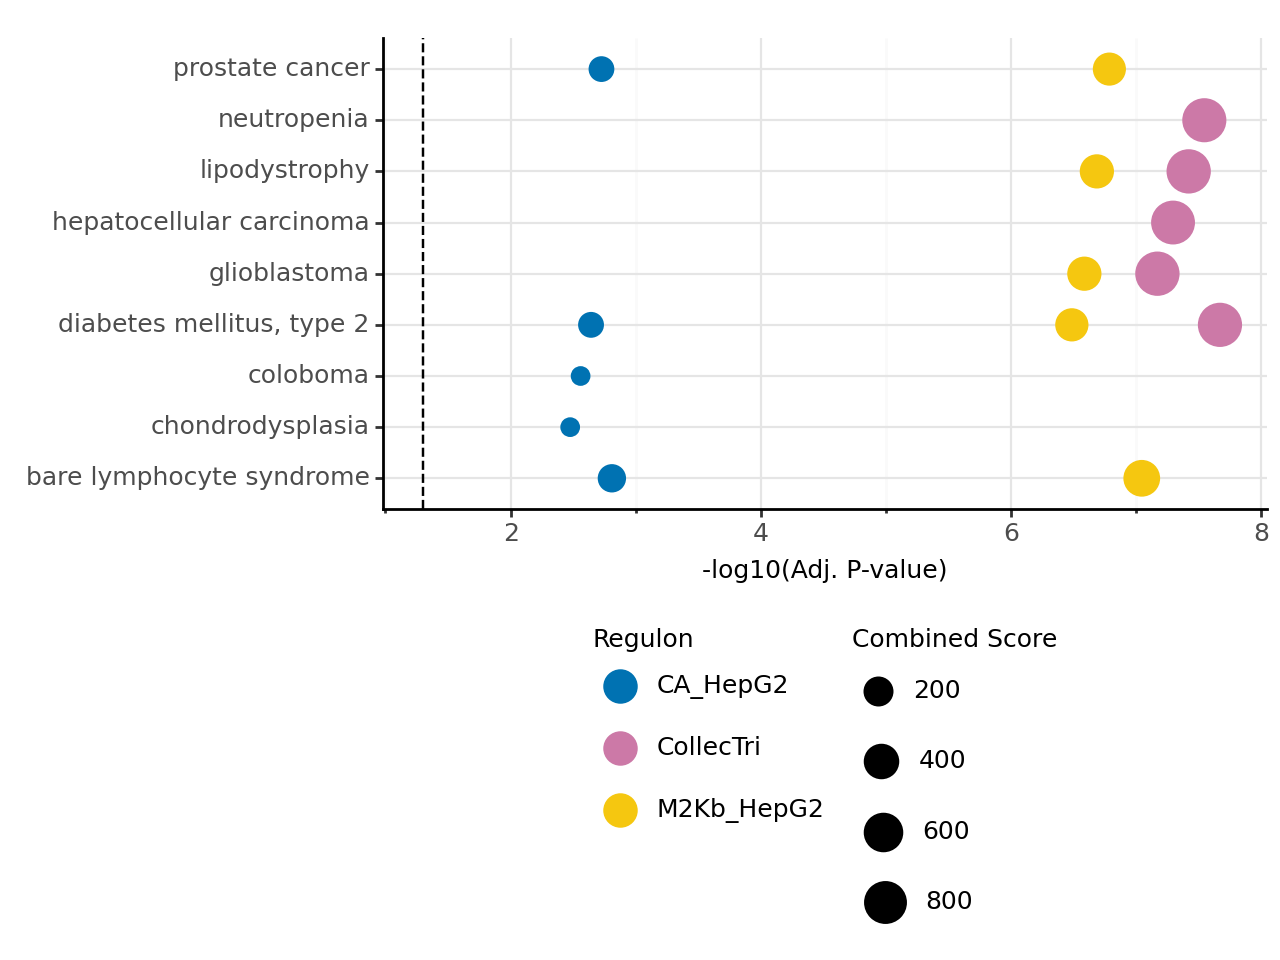

<Figure Size: (640 x 480)>

In [48]:
hep_omim_enrich["-log10(Adj. P-value)"] = - np.log10(hep_omim_enrich["Adjusted P-value"])
hep_omim_enrich = hep_omim_enrich.loc[hep_omim_enrich["Adjusted P-value"] < 0.05]
hep_omim_enrich.describe()

p = plot_enrich(hep_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/hep_go_enrich_omim.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/hep_go_enrich_disreg.svg


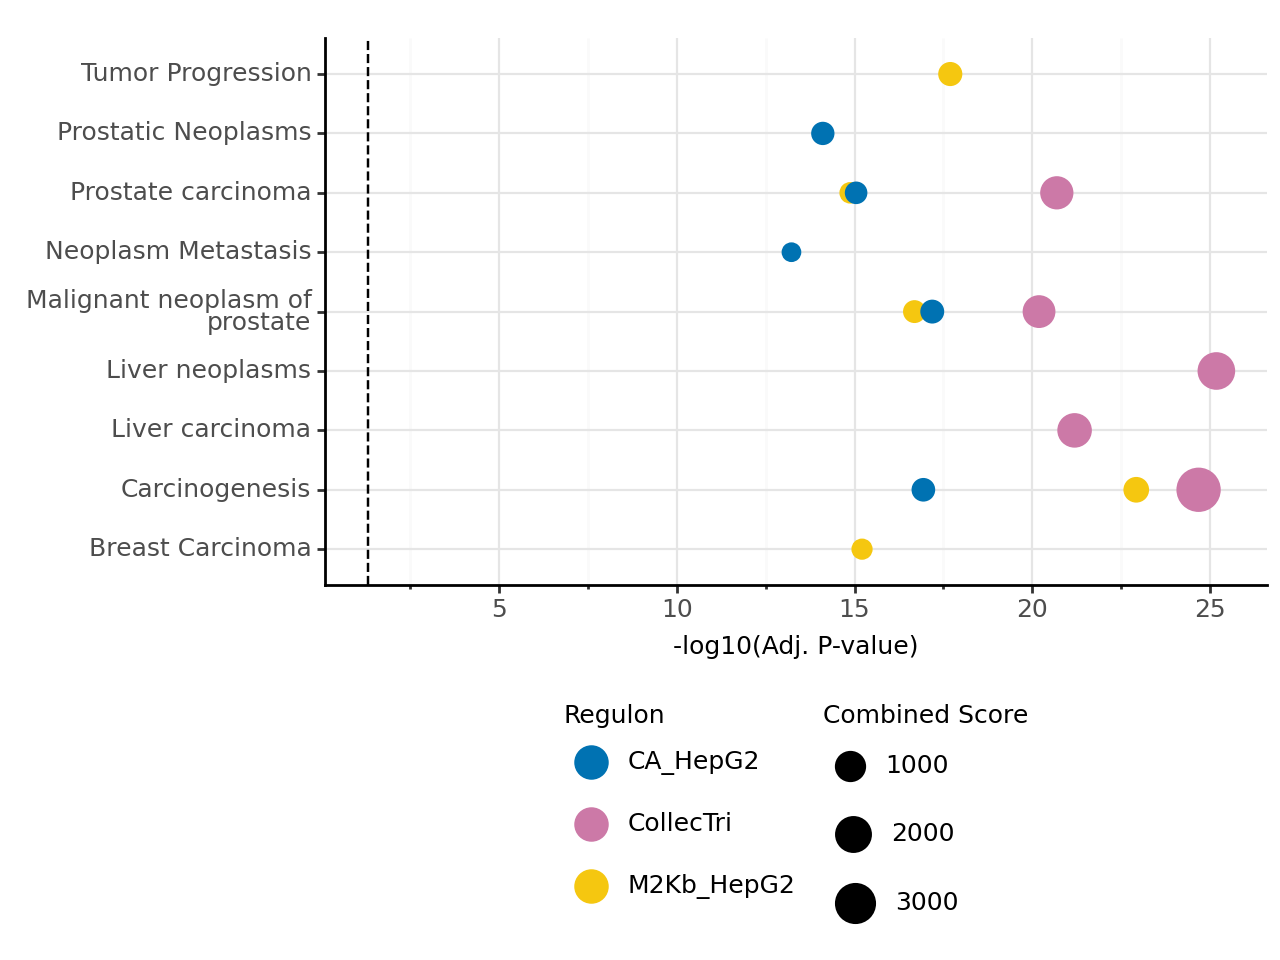

<Figure Size: (640 x 480)>

In [49]:
hep_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(hep_disreg_enrich["Adjusted P-value"])
hep_disreg_enrich = hep_disreg_enrich.loc[hep_disreg_enrich["Adjusted P-value"] < 0.05]
hep_disreg_enrich.describe()

p = plot_enrich(hep_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/hep_go_enrich_disreg.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/hep_go_enrich_cosmic.svg


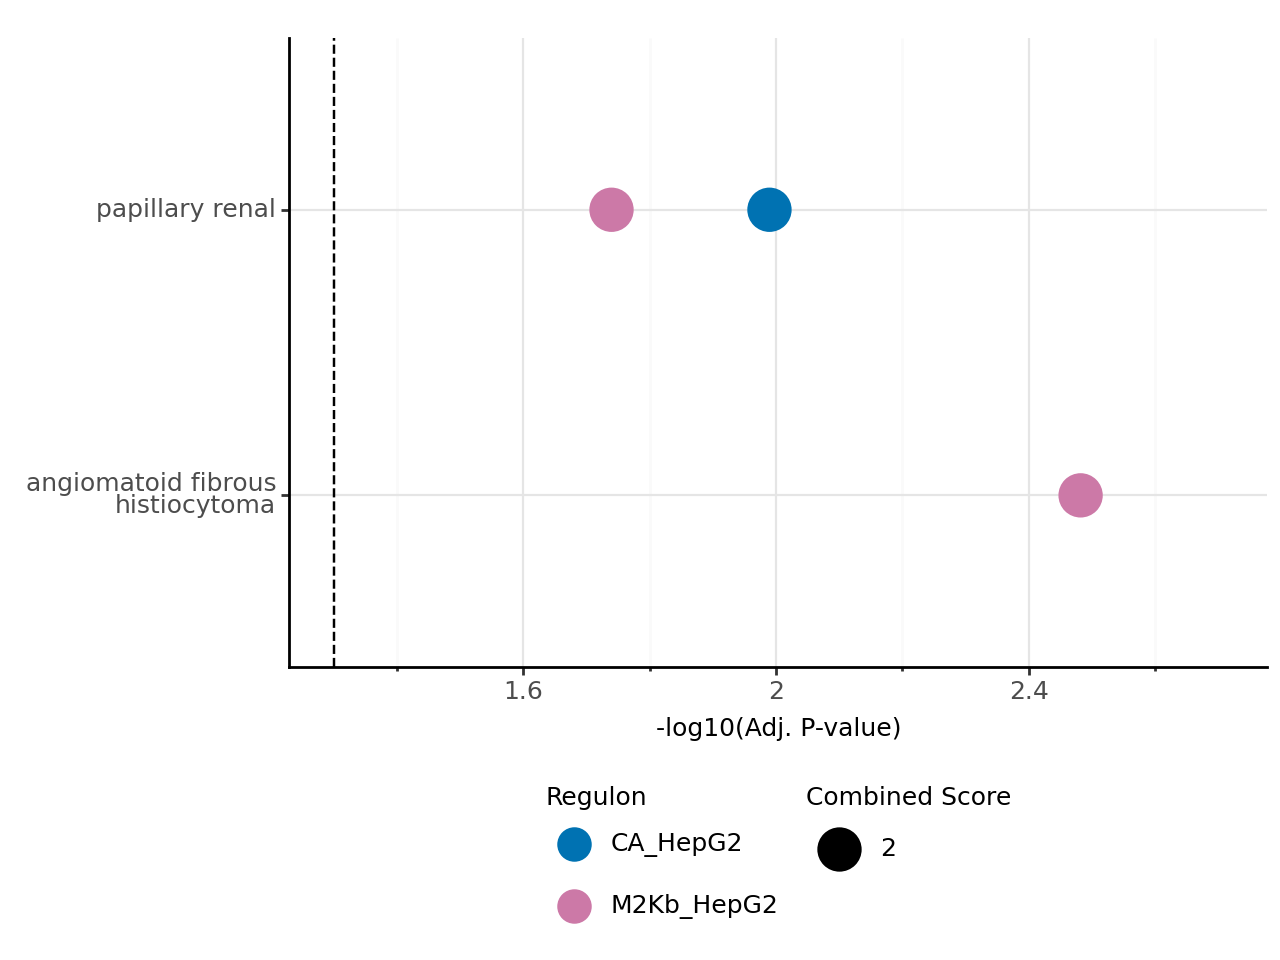

<Figure Size: (640 x 480)>

In [50]:
hep_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(hep_cosmic_enrich["Adjusted P-value"])
hep_cosmic_enrich = hep_cosmic_enrich.loc[hep_cosmic_enrich["Adjusted P-value"] < 0.05]
hep_cosmic_enrich.describe()

p = plot_enrich(hep_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/hep_go_enrich_cosmic.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [51]:
megaheat.to_csv("../data/3-tf_activity/hep_activity_estimates.tsv", sep="\t", index=False)

In [52]:

megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(0)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


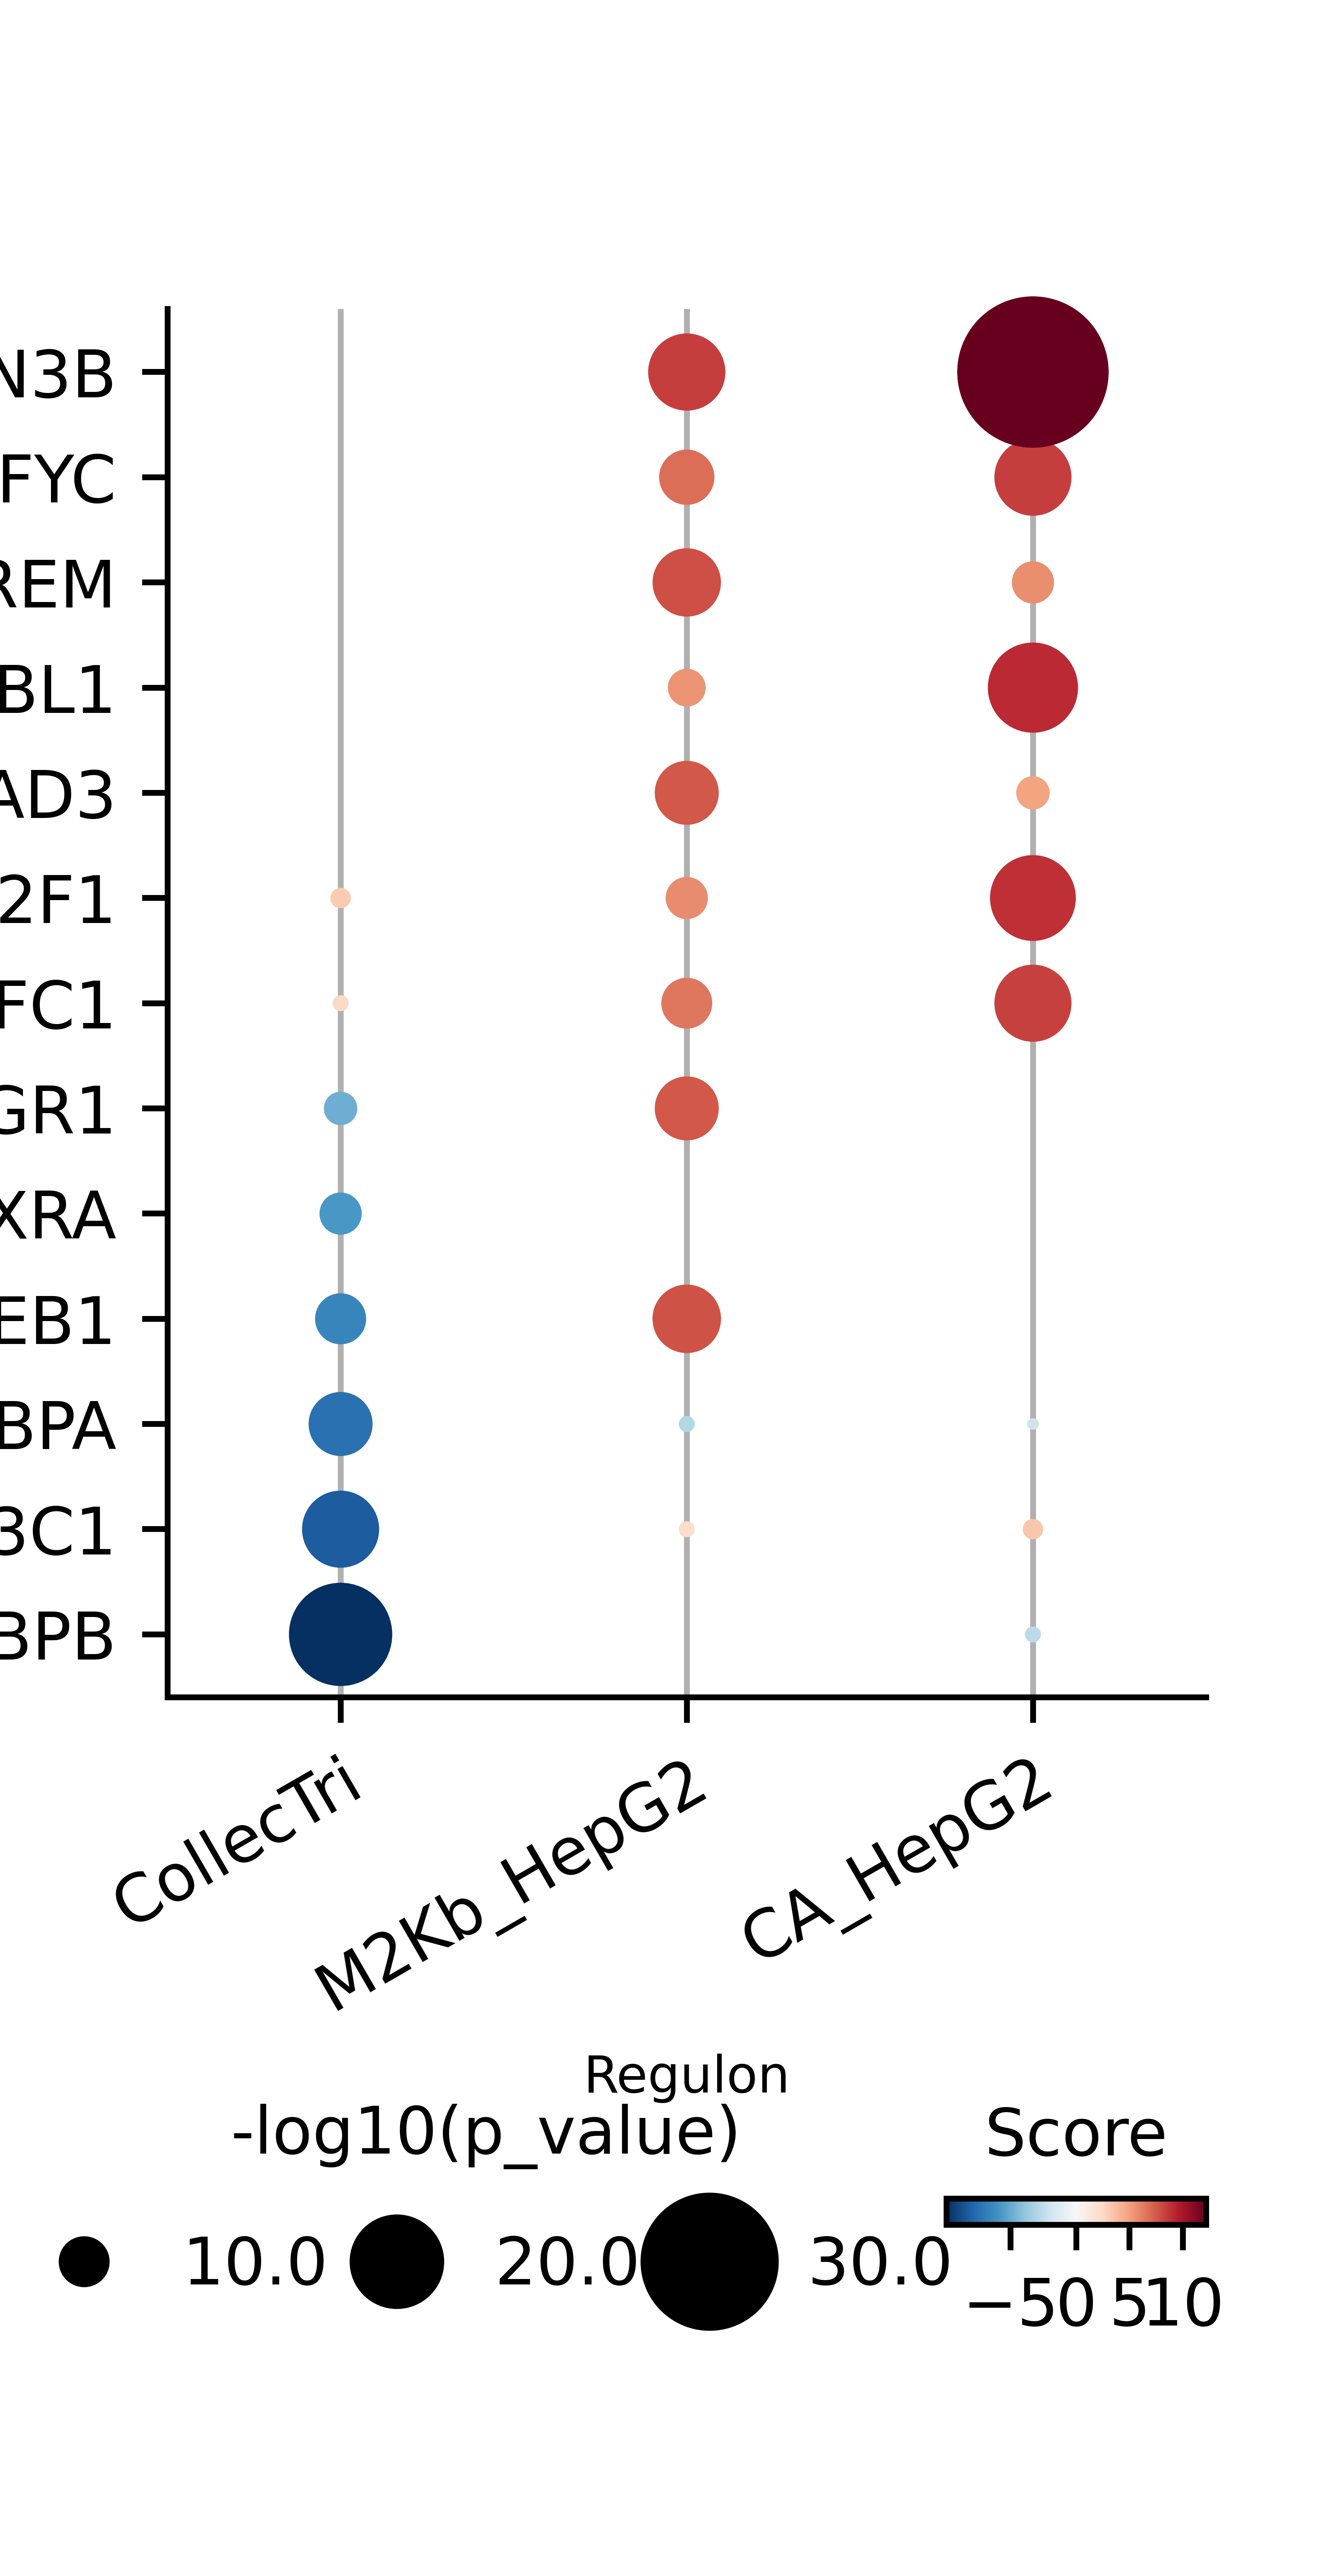

In [53]:
out = pd.DataFrame()
#interesting_tf = ["E2E1", "ETV4", "MTA1", "MYBL2", "NCO3", "PPARG"]
interesting_tf = []
for net in ["M2Kb_HepG2", "CollecTri", "CA_HepG2"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_HepG2", "CA_HepG2"])], scale=0.1)
plt.savefig("../plots/3-tf_activity/hep_activity_clustermap.svg", dpi=720, format="svg")

In [54]:
out

,score,p_value,Network,TF,log_p
CREB1,-6.496742,8.574833e-11,CollecTri,CREB1,10.0
EGR1,-4.793391,1.662074e-06,CollecTri,EGR1,6.0
SMAD3,4.939712,7.942907e-07,CA_HepG2,SMAD3,6.0
CREM,5.609333,2.081859e-08,CA_HepG2,CREM,8.0
EGR1,7.548317,4.770303e-14,M2Kb_HepG2,EGR1,13.0
SMAD3,7.551165,4.667681e-14,M2Kb_HepG2,SMAD3,13.0
CREB1,7.698920,1.494061e-14,M2Kb_HepG2,CREB1,14.0
CREM,7.798066,6.874625e-15,M2Kb_HepG2,CREM,14.0
SIN3B,8.366405,6.684123e-17,M2Kb_HepG2,SIN3B,16.0
SIN3B,12.162707,8.232882e-34,CA_HepG2,SIN3B,33.0


In [55]:
print(megaheat[megaheat.Network == "M2Kb_HepG2"].sort_values("score").to_string())

            score       p_value     Network       TF  log_p
JUN     -3.562881  3.684137e-04  M2Kb_HepG2      JUN    3.0
NFIL3   -3.133866  1.729889e-03  M2Kb_HepG2    NFIL3    3.0
CEBPA   -2.891483  3.842059e-03  M2Kb_HepG2    CEBPA    2.0
ATF4    -2.256242  2.407569e-02  M2Kb_HepG2     ATF4    2.0
FUS     -2.067708  3.869160e-02  M2Kb_HepG2      FUS    1.0
SMARCC2 -1.992849  4.630351e-02  M2Kb_HepG2  SMARCC2    1.0
HNF1A    2.058208  3.959445e-02  M2Kb_HepG2    HNF1A    1.0
IKZF1    2.162631  3.059181e-02  M2Kb_HepG2    IKZF1    2.0
HNF4G    2.170235  3.001114e-02  M2Kb_HepG2    HNF4G    2.0
ZEB1     2.197914  2.797669e-02  M2Kb_HepG2     ZEB1    2.0
NR3C1    2.240324  2.509045e-02  M2Kb_HepG2    NR3C1    2.0
ZNF24    2.263246  2.364059e-02  M2Kb_HepG2    ZNF24    2.0
SSRP1    2.299716  2.148358e-02  M2Kb_HepG2    SSRP1    2.0
ETS1     2.300609  2.143303e-02  M2Kb_HepG2     ETS1    2.0
HSF1     2.482861  1.304849e-02  M2Kb_HepG2     HSF1    2.0
PBX2     2.505868  1.222994e-02  M2Kb_He

In [56]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_HepG2"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(10))
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_kegg_enrich_m2kb_hepg2.tsv", sep="\t", index=False)

          Gene_set                                     Term Overlap  \
0  KEGG_2021_Human  Transcriptional misregulation in cancer  17/192   
1  KEGG_2021_Human  Human T-cell leukemia virus 1 infection  14/219   
2  KEGG_2021_Human     Maturity onset diabetes of the young    5/26   
3  KEGG_2021_Human                              Hepatitis B   9/162   
4  KEGG_2021_Human                      Cellular senescence   8/156   
5  KEGG_2021_Human      Antigen processing and presentation    6/78   
6  KEGG_2021_Human                    Wnt signaling pathway   8/166   
7  KEGG_2021_Human        Thyroid hormone signaling pathway   7/121   
8  KEGG_2021_Human                 Hepatocellular carcinoma   8/168   
9  KEGG_2021_Human                               Cell cycle   7/124   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  2.715848e-14      3.883663e-12            0                     0   
1  4.534268e-10      3.242002e-08            0                     0   
2 

In [57]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

             score       p_value    Network        TF  log_p
CEBPB    -9.893742  5.569171e-23  CollecTri     CEBPB   22.0
NR3C1    -8.221179  2.249704e-16  CollecTri     NR3C1   16.0
CEBPA    -7.373647  1.783837e-13  CollecTri     CEBPA   13.0
CREB1    -6.496742  8.574833e-11  CollecTri     CREB1   10.0
RXRA     -5.765996  8.343881e-09  CollecTri      RXRA    8.0
SP1      -5.754485  8.930897e-09  CollecTri       SP1    8.0
HNF4A    -5.592871  2.288656e-08  CollecTri     HNF4A    8.0
ARNT     -5.466503  4.693733e-08  CollecTri      ARNT    7.0
KLF6     -4.899792  9.735335e-07  CollecTri      KLF6    6.0
EGR1     -4.793391  1.662074e-06  CollecTri      EGR1    6.0
NFE2L2   -4.656438  3.256243e-06  CollecTri    NFE2L2    5.0
USF1     -4.499864  6.871923e-06  CollecTri      USF1    5.0
TP53     -4.306445  1.673878e-05  CollecTri      TP53    5.0
SSRP1    -4.070048  4.734346e-05  CollecTri     SSRP1    4.0
PPARGC1A -3.896009  9.839011e-05  CollecTri  PPARGC1A    4.0
HNF1A    -3.804808  1.42

In [58]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(10))
enr.results.to_csv("../data/3-tf_disease_enrichment/hep_kegg_enrich_collectri.tsv", sep="\t", index=False)

          Gene_set                                               Term Overlap  \
0  KEGG_2021_Human            Transcriptional misregulation in cancer  10/192   
1  KEGG_2021_Human            Human T-cell leukemia virus 1 infection  10/219   
2  KEGG_2021_Human                                 Pathways in cancer  11/531   
3  KEGG_2021_Human                                   Cushing syndrome   7/155   
4  KEGG_2021_Human  Parathyroid hormone synthesis, secretion and a...   6/106   
5  KEGG_2021_Human                               Viral carcinogenesis   7/203   
6  KEGG_2021_Human                                          Mitophagy    5/68   
7  KEGG_2021_Human                                     Thyroid cancer    4/37   
8  KEGG_2021_Human                                        Hepatitis B   6/162   
9  KEGG_2021_Human                       Longevity regulating pathway   5/102   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  3.119670e-11      4.117964e-09   